In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

BASE_DIR = Path.cwd()
train_path = BASE_DIR / "mitbih_train.csv"
test_path  = BASE_DIR / "mitbih_test.csv"

print("Notebook folder:", BASE_DIR)
print("Train exists:", train_path.exists(), "|", train_path)
print("Test exists :", test_path.exists(),  "|", test_path)

train_df = pd.read_csv(train_path, header=None)
test_df  = pd.read_csv(test_path, header=None)

print(f"Training set: {train_df.shape}")
print(f"Test set:     {test_df.shape}")
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

display(train_df.head())


Notebook folder: p:\natural language\ECG Heart
Train exists: True | p:\natural language\ECG Heart\mitbih_train.csv
Test exists : True | p:\natural language\ECG Heart\mitbih_test.csv
Training set: (87554, 188)
Test set:     (21892, 188)
GPU available: False


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training distribution:
  0 (Normal): 72471 (82.77%)
  1 (Supraventricular): 2223 (2.54%)
  2 (Ventricular): 5788 (6.61%)
  3 (Fusion): 641 (0.73%)
  4 (Unknown): 6431 (7.35%)

Test distribution:
  0 (Normal): 18118 (82.76%)
  1 (Supraventricular): 556 (2.54%)
  2 (Ventricular): 1448 (6.61%)
  3 (Fusion): 162 (0.74%)
  4 (Unknown): 1608 (7.35%)



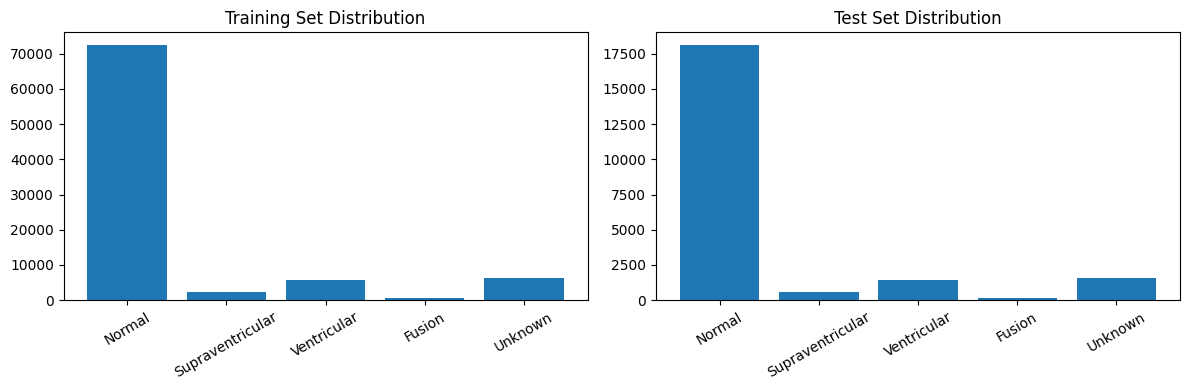

In [ ]:
X_train_full = train_df.iloc[:, :-1].values.astype(np.float32)
y_train_full = train_df.iloc[:, -1].values.astype(int)

X_test = test_df.iloc[:, :-1].values.astype(np.float32)
y_test = test_df.iloc[:, -1].values.astype(int)

class_names = {0: "Normal", 1: "Supraventricular", 2: "Ventricular", 3: "Fusion", 4: "Unknown"}
num_classes = len(class_names)

def print_distribution(y, title):
    uniq, cnt = np.unique(y, return_counts=True)
    print(title)
    for u, c in zip(uniq, cnt):
        print(f"  {u} ({class_names[u]}): {c} ({c/len(y)*100:.2f}%)")
    print()

print_distribution(y_train_full, "Training distribution:")
print_distribution(y_test, "Test distribution:")

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

uniq, cnt = np.unique(y_train_full, return_counts=True)
ax[0].bar([class_names[i] for i in uniq], cnt)
ax[0].set_title("Training Set Distribution")
ax[0].tick_params(axis="x", rotation=30)

uniq2, cnt2 = np.unique(y_test, return_counts=True)
ax[1].bar([class_names[i] for i in uniq2], cnt2)
ax[1].set_title("Test Set Distribution")
ax[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


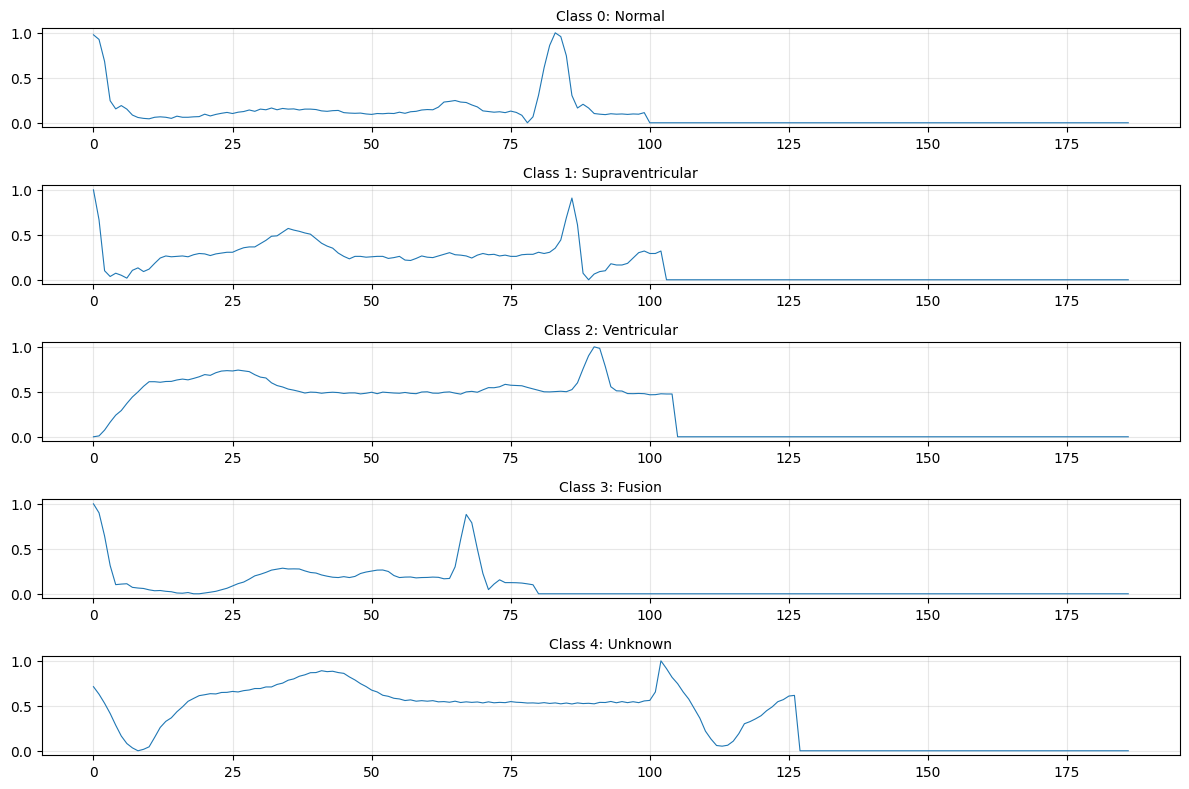

In [ ]:
plt.figure(figsize=(12, 8))

for cls in range(num_classes):
    idx = np.where(y_train_full == cls)[0][0]  
    plt.subplot(num_classes, 1, cls+1)
    plt.plot(X_train_full[idx], linewidth=0.8)
    plt.title(f"Class {cls}: {class_names[cls]}", fontsize=10)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

X_train_seq = X_train_sc.reshape(X_train_sc.shape[0], X_train_sc.shape[1], 1)
X_val_seq   = X_val_sc.reshape(X_val_sc.shape[0], X_val_sc.shape[1], 1)
X_test_seq  = X_test_sc.reshape(X_test_sc.shape[0], X_test_sc.shape[1], 1)

print("X_train_seq:", X_train_seq.shape)
print("X_val_seq:  ", X_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape)


X_train_seq: (74420, 187, 1)
X_val_seq:   (13134, 187, 1)
X_test_seq:  (21892, 187, 1)


In [11]:
model = keras.Sequential([
    layers.Input(shape=(X_train_seq.shape[1], 1)),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,141 (74.77 KB)

 Trainable params: 19,141 (74.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 60s 50ms/step - accuracy: 0.8261 - loss: 0.6685 - val_accuracy: 0.8286 - val_loss: 0.6349
Epoch 2/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 69s 60ms/step - accuracy: 0.8287 - loss: 0.6053 - val_accuracy: 0.8279 - val_loss: 0.5758
Epoch 3/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.8297 - loss: 0.6392 - val_accuracy: 0.8281 - val_loss: 0.6427
Epoch 4/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 71s 61ms/step - accuracy: 0.8278 - loss: 0.6364 - val_accuracy: 0.8277 - val_loss: 0.5825
Epoch 5/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.8320 - loss: 0.5600 - val_accuracy: 0.8483 - val_loss: 0.5251
Epoch 6/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - accuracy: 0.8568 - loss: 0.4911 - val_accuracy: 0.8917 - val_loss: 0.3684
Epoch 7/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 70s 60ms/step - accuracy: 0.8794 - loss: 0.4331 - val_accuracy: 0.8987 - val_loss: 0.3869
Epoch 8/40
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 65s 56ms/step - accuracy: 0.8901 -

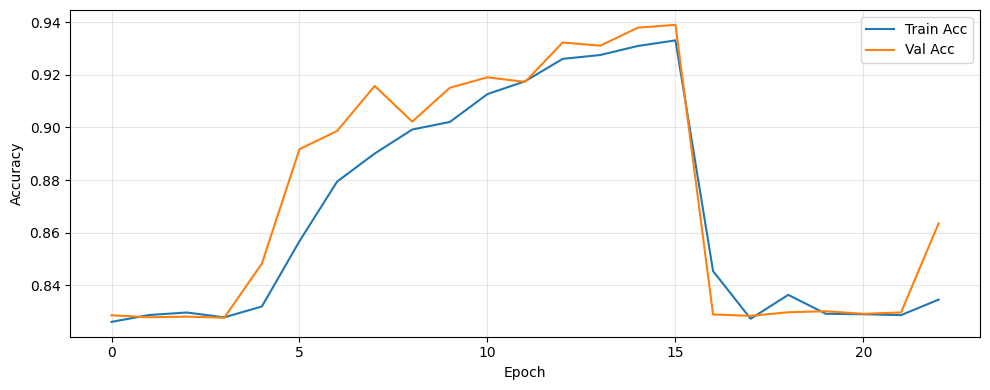

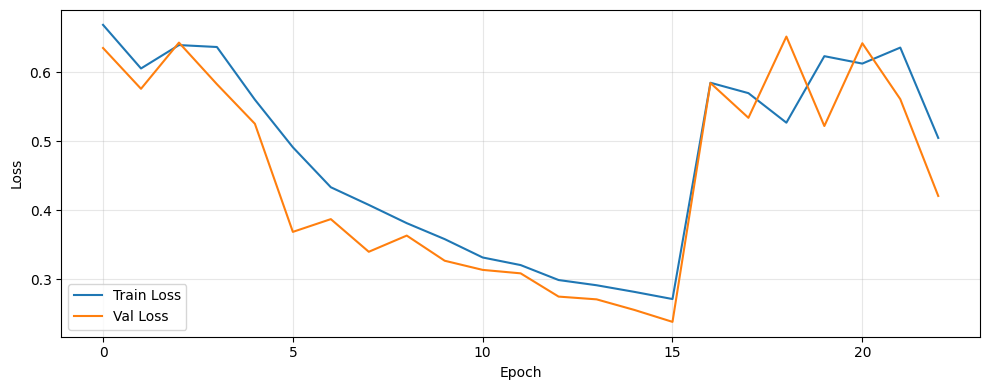

In [12]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
]

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot curves
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


Test Accuracy: 0.9366
Test Macro F1: 0.5601

Classification Report:
                  precision    recall  f1-score   support

          Normal       0.94      0.99      0.97     18118
Supraventricular       0.91      0.07      0.13       556
     Ventricular       0.87      0.72      0.79      1448
          Fusion       0.00      0.00      0.00       162
         Unknown       0.95      0.88      0.91      1608

        accuracy                           0.94     21892
       macro avg       0.73      0.53      0.56     21892
    weighted avg       0.93      0.94      0.92     21892



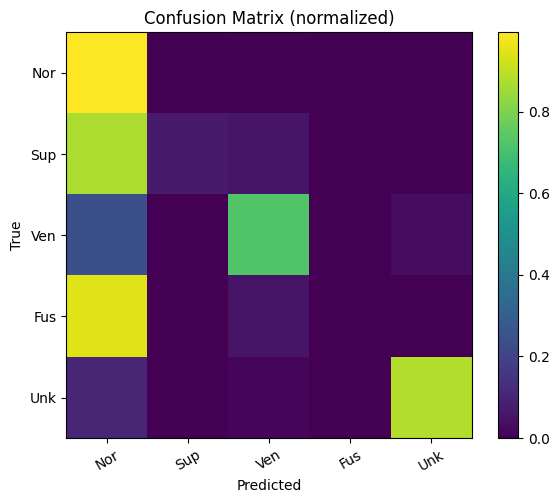

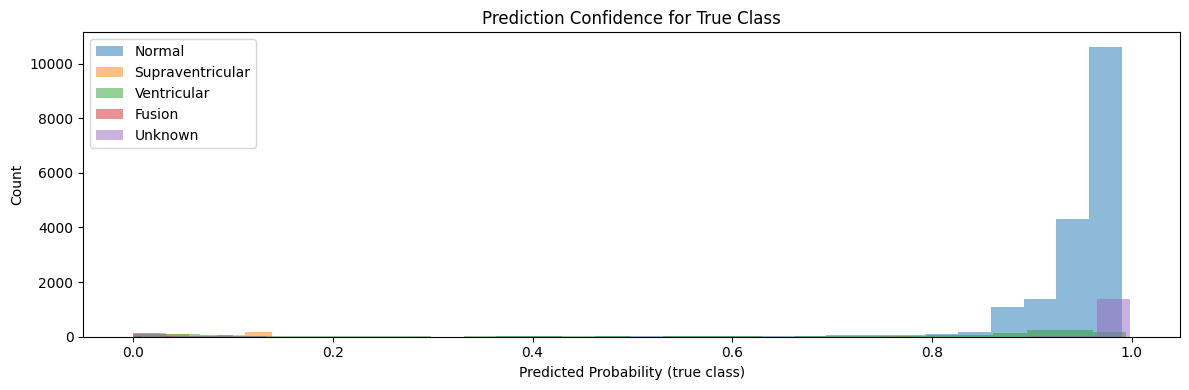

In [ ]:
y_proba = model.predict(X_test_seq, verbose=0)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Macro F1: {macro_f1:.4f}\n")

print("Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=[class_names[i] for i in range(num_classes)],
    zero_division=0
))


cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("Confusion Matrix (normalized)")
plt.colorbar()

ticks = np.arange(num_classes)
plt.xticks(ticks, [class_names[i][:3] for i in range(num_classes)], rotation=30)
plt.yticks(ticks, [class_names[i][:3] for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))
for cls in range(num_classes):
    cls_mask = (y_test == cls)
    plt.hist(y_proba[cls_mask, cls], bins=30, alpha=0.5, label=class_names[cls])
plt.title("Prediction Confidence for True Class")
plt.xlabel("Predicted Probability (true class)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
